In [1]:
%pip install kaggle
%pip install scikit-learn pandas numpy imbalanced-learn xgboost matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import os
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, log_loss
#For Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# For Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
#For Decision Tree
from sklearn.tree import DecisionTreeClassifier
#For KNN
from sklearn.neighbors import KNeighborsClassifier
#For SVM
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#For XGBoot
from xgboost import XGBClassifier

import time
import pickle


import os




In [3]:
# Use the raw URL for the CSV file
url = "https://raw.githubusercontent.com/DannyPhongcoderso1/WebVulnerabilities/main/data/csic_database.csv"

# Specify the delimiter if necessary (e.g., ';' or '\t')
df = pd.read_csv(url, delimiter=',', on_bad_lines='skip')

# **Preprocessing data**

***Read data and check informations***
- Column title
- Number of records: n_samples
- Number of features: n_feature

In [4]:
print(df.head())
print("\n")
# Read number of rows and columns
n_features = df.shape[1]
n_samples = df.shape[0]
print("Number of features:", n_features)
print("Number of samples:", n_samples)




  Unnamed: 0 Method                                         User-Agent  \
0     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
1     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
2     Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
3     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
4     Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   

     Pragma Cache-Control                                             Accept  \
0  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
1  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
2  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
3  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
4  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   

                    Accept-encoding               Accept-charset language 

In [5]:
#check columns names
print("\n")
print("Columns:",df.columns)



Columns: Index(['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content',
       'classification', 'URL'],
      dtype='object')


***Visualizing dataset***



Sample number by Normal and Anomalous: 
   Unnamed: 0  count
0     Normal  36000
1  Anomalous  25065
lable distribution: 
classification
0    0.589536
1    0.410464
Name: proportion, dtype: float64
Data visuallization:


Text(0.5, 1.0, 'Data Visualization')

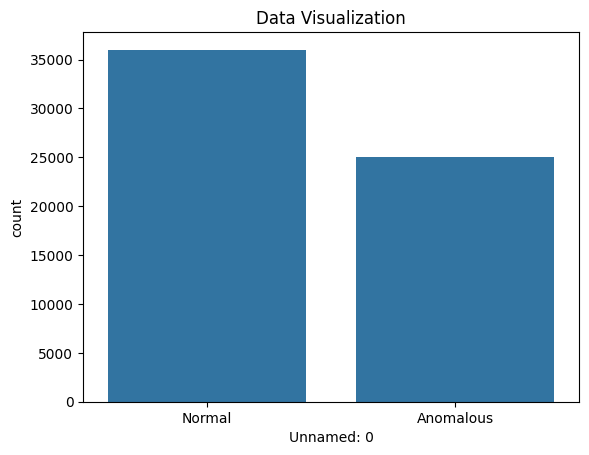

In [6]:
print("\n")
print("Sample number by Normal and Anomalous: \n",df['Unnamed: 0'].value_counts().reset_index(name='count').rename(columns={'index': 'type'}))

#label encoding
print("lable distribution: ")
print(df['classification'].value_counts(normalize=True))

#data visualization
print("Data visuallization:")
sns.countplot(data=df, x='Unnamed: 0')
plt.title('Data Visualization')

In [7]:
#Rename Unnamed: 0 to label
df.rename(columns={'Unnamed: 0': 'lable'}, inplace=True)
print(df.isnull().sum())

lable                  0
Method                 0
User-Agent             0
Pragma                 0
Cache-Control          0
Accept               397
Accept-encoding        0
Accept-charset         0
language               0
host                   0
cookie                 0
content-type       43088
connection             0
lenght             43088
content            43088
classification         0
URL                    0
dtype: int64


# **Cleaning data**

In [8]:
# replace NaN values with common values
df['Accept'] = df['Accept'].fillna(df['Accept'].mode()[0])
print(df['Accept'].isnull().sum())

0


In [9]:
df['lenght'] = df['lenght'].fillna('0')
df['content-type'] = df['content-type'].fillna('None')
df['content'] = df['content'].fillna('None')
df['is_post'] = df['Method'].apply(lambda x: 1 if x == 'POST' else 0)

In [10]:
print(df.isnull().sum())

lable              0
Method             0
User-Agent         0
Pragma             0
Cache-Control      0
Accept             0
Accept-encoding    0
Accept-charset     0
language           0
host               0
cookie             0
content-type       0
connection         0
lenght             0
content            0
classification     0
URL                0
is_post            0
dtype: int64


In [11]:

df.drop(columns=['lable'],  errors='ignore', inplace=True)
print(df.columns)


Index(['Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept',
       'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie',
       'content-type', 'connection', 'lenght', 'content', 'classification',
       'URL', 'is_post'],
      dtype='object')


In [12]:
#------------- Feature extraction -----------
# Define malicious keywords
malicious_keywords = [
    'SELECT', 'UNION', 'DROP', 'DELETE', 'FROM', 'WHERE', 'OR', 'LIKE', 'AND', '1=1', '--', '\'',
    'SCRIPT', 'javascript', 'alert', 'iframe', 'src=', 'onerror', 'prompt', 'confirm', 'eval', 'onload',
    'mouseover', 'onunload', 'document.', 'window.', 'xmlhttprequest', 'xhr', 'cookie',
    'tamper', 'vaciar', 'carrito', 'incorrect', 'pwd', 'login', 'password', 'id',
    '%0D', '%0A', '.php', '.js', 'admin', 'administrator'
]

# Feature extraction from URL
df['url_length'] = df['URL'].apply(len)
df['url_special_chars'] = df['URL'].apply(lambda x: len(re.findall(r'[%;=<>\/&\'"()\[\]#\-\+]', x)))
df['url_malicious_keywords'] = df['URL'].apply(lambda x: sum(1 for kw in malicious_keywords if kw.lower() in x.lower()))
df['url_params_count'] = df['URL'].apply(lambda x: x.count('&') + 1 if '?' in x else 0)

# Feature extraction from content
df['content_length'] = df['content'].fillna('').apply(len)
df['content_special_chars'] = df['content'].fillna('').apply(lambda x: len(re.findall(r'[%;=<>\/&\'"()\[\]#\-\+]', x)))
df['content_malicious_keywords'] = df['content'].fillna('').apply(lambda x: sum(1 for kw in malicious_keywords if kw.lower() in x.lower()))

# Check Feature Distribution
print("PFeature Distribution by Class:")
print(df.groupby('classification')[['url_length', 'url_special_chars', 'url_malicious_keywords', 'url_params_count',
                                            'content_length', 'content_special_chars', 'content_malicious_keywords']].mean())

# Save Feature contribution
df.to_csv('dataset_with_features.csv', index=False)
print("Feature Distribution was saved!")

PFeature Distribution by Class:
                url_length  url_special_chars  url_malicious_keywords  \
classification                                                          
0                78.985944           8.930694                1.290833   
1               106.611769          13.273050                2.087133   

                url_params_count  content_length  content_special_chars  \
classification                                                            
0                       1.166667       23.458167               2.875139   
1                       2.233034       50.990824               7.418033   

                content_malicious_keywords  
classification                              
0                                 0.513056  
1                                 1.123399  
Feature Distribution was saved!


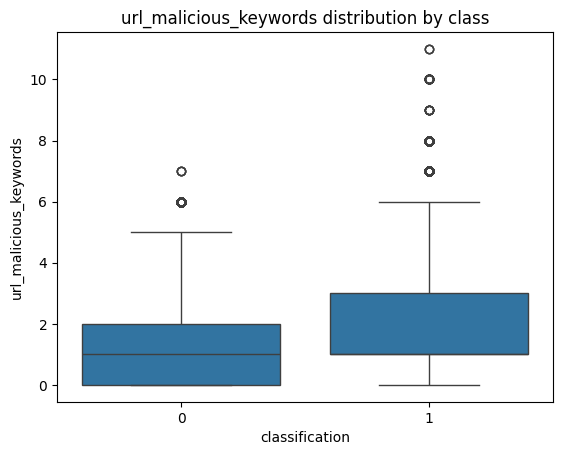

In [13]:
# Feature Distribution visuallization
sns.boxplot(x='classification', y='url_malicious_keywords', data=df)
plt.title('url_malicious_keywords distribution by class')
plt.show()

In [14]:
df['content'] = df['content'].fillna(' ')
url_tfidf = TfidfVectorizer(max_features=1000, lowercase=True, token_pattern=r'(?u)\b\w+\b')
url_features = url_tfidf.fit_transform(df['URL']).toarray()
url_feature_names = url_tfidf.get_feature_names_out()
print("TF-IDF URL matrix size:", url_features.shape)
print("Some words in the URL vocabulary:", url_feature_names[:10])

TF-IDF URL matrix size: (61065, 1000)
Some words in the URL vocabulary: ['0' '09390' '1' '10' '100' '102' '103' '104' '105' '106']


In [15]:
# Generate TF-IDF for content
content_tfidf = TfidfVectorizer(max_features=1000, lowercase=True, token_pattern=r'(?u)\b\w+\b')
content_features = content_tfidf.fit_transform(df['content']).toarray()
content_feature_names = content_tfidf.get_feature_names_out()
print("TF-IDF content matrix size:", content_features.shape)
print("Some words in content vocabulary:", content_feature_names[:10])

TF-IDF content matrix size: (61065, 1000)
Some words in content vocabulary: ['0' '09390' '1' '10' '100' '102' '103' '104' '105' '106']


In [16]:
# Encode category columns using One-Hot Encoding
# Encoding Method and content-type
# One-Hot Encoding 2 cột: 'Method' và 'content-type'
df = pd.get_dummies(
    df,                          # DataFrame gốc
    columns=['Method', 'content-type'],    # Cột cần mã hóa
    prefix=['Method', 'content-type'],     # Tiền tố cho tên cột mới
    drop_first=True                        # Bỏ cột đầu tiên (giảm đa cộng tuyến)
)

In [17]:
manual_features = df[['url_length', 'url_special_chars', 'url_malicious_keywords', 'url_params_count',
                               'content_length', 'content_special_chars', 'content_malicious_keywords',
                               'is_post']]  

one_hot_features = df.filter(like='Method_|content-type_')
feature_matrix = np.hstack([
    manual_features.values, 
    one_hot_features.values, 
    url_features, 
    content_features
])

#normalize the feature matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)



In [18]:
print("Total features matrix size:", feature_matrix.shape)
print("Is there any NaN in the matrix?", np.isnan(feature_matrix).sum())
print("The first 10 of feature samples:", feature_matrix[0, :10])

Total features matrix size: (61065, 2008)
Is there any NaN in the matrix? 0
The first 10 of feature samples: [-0.56025611 -0.50971368 -0.3964348  -0.4469256  -0.41297921 -0.42000477
 -0.54358599 -0.63582807 -0.03536649 -0.01452911]


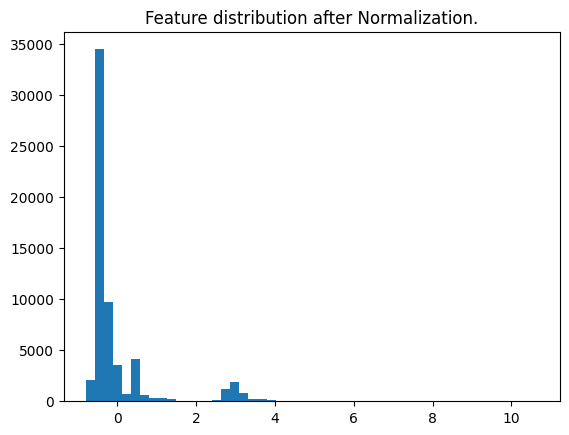

In [19]:
# Save after Normalization
np.save('feature_matrix_scaled.npy', feature_matrix)
np.save('labels.npy', df['classification'].values)  

joblib.dump(scaler, 'scaler.pkl')

# Re-check & Visualization
plt.hist(feature_matrix[:, 0], bins=50)  
plt.title('Feature distribution after Normalization.')
plt.show()

***Data Balancing***
- Problem: Currently valid:toxic sample ratio (~36,000:25,000, ratio ~59:41).
- Resolution: Need to perform data balance

In [20]:
#using SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(feature_matrix, df['classification'].values)

# Re-check & Visualization
print("After SMOTE, the number of samples in each class:")
print(pd.Series(y_resampled).value_counts(normalize=True))

After SMOTE, the number of samples in each class:
0    0.5
1    0.5
Name: proportion, dtype: float64


In [21]:
# Save balanced Data
np.save('X_resampled.npy', X_resampled)
np.save('y_resampled.npy', y_resampled)

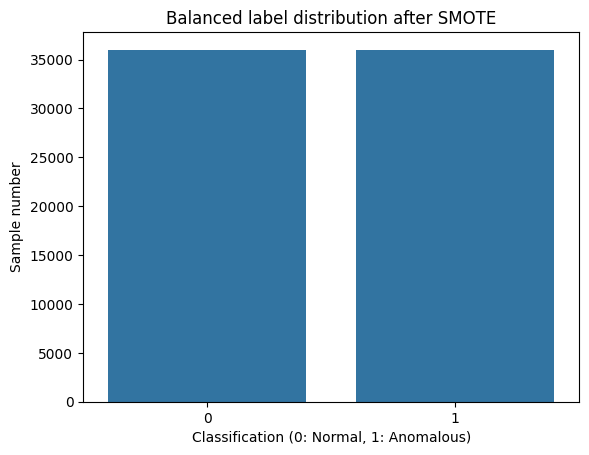

In [22]:
# Balanced Data visualization
sns.countplot(x=y_resampled)
plt.title('Balanced label distribution after SMOTE')
plt.xlabel('Classification (0: Normal, 1: Anomalous)')
plt.ylabel('Sample number')
plt.show()

***Split training data***


In [23]:
# Train:Val:Test theo tỷ lệ 7:2:1
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Save training data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

Train: (50400, 2008) Val: (7128, 2008) Test: (14472, 2008)
